### Thumbtack Weekly Analysis - 8/3/16
Run the following report to get an idea of what kind of use Thumbtack is getting from Atipica.

In [1]:
import datetime
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
f = open('postgres.txt', 'r')
dct = {}
keys = ['database', 'user', 'password', 'host', 'port']
for key, line in zip(keys, f.readlines()):
    dct[key] = line.strip()

In [3]:
def load_sql(query):
    conn = psycopg2.connect(database=dct['database'], user=dct['user'],
                            password=dct['password'], host=dct['host'],
                            port=dct['port'])
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

### SQL queries to get Thumbtack data from Postgres DB

In [4]:
query_ct = """
DROP TABLE IF EXISTS signals;
CREATE TEMP TABLE signals as 
(SELECT 
	p.id,
	p.title, 
	count(pi.trend_id) as signals
FROM positions p
INNER JOIN position_inputs pi
ON p.id = pi.position_id
WHERE p.company_id = 8
GROUP BY 1)
;

SELECT 
	p.title, 
	count(l.id) as leads,
	sum(case when l.is_match = True then 1 else 0 end) as matches,
	sum(case when a.roles @> ARRAY['diverse'] then 1 else 0 end) as diverse,
    s.signals
FROM positions p
INNER JOIN leads l
ON p.id = l.position_id
INNER JOIN applicants a
ON a.id = l.applicant_id
INNER JOIN signals s
ON p.id = s.id
WHERE p.company_id = 8
GROUP BY 5,1
;
"""

In [5]:
query_le = """
SELECT 
	ld.title, round(ld.diverse / ld.leads, 3) as per_leads_div
FROM
	(SELECT 
		p.title as title,
		count(l.id)*1.0 as leads,
		sum(case when a.roles @> ARRAY['diverse'] then 1 else 0 end)*1.0 as diverse
	FROM positions p
	INNER JOIN leads l
	ON p.id = l.position_id
	INNER JOIN applicants a
	ON a.id = l.applicant_id
	WHERE p.company_id = 8
	GROUP BY 1) as ld
;
"""

In [6]:
query_ma = """
SELECT 
	ld.title, round(ld.diverse / ld.matches, 3) as per_match_div
FROM
	(SELECT 
		p.title as title,
		sum(case when l.is_match = True then 1 end) as matches,
		sum(case when l.is_match = True
		    AND a.roles @> ARRAY['diverse'] then 1 end)*1.0 as diverse
	FROM positions p
	INNER JOIN leads l
	ON p.id = l.position_id
	INNER JOIN applicants a
	ON a.id = l.applicant_id
	WHERE p.company_id = 8
	GROUP BY 1) as ld
;
"""

### Load and format the data in python

In [7]:
df_ct = load_sql(query_ct)
df_le = load_sql(query_le)
df_ma = load_sql(query_ma)

In [8]:
df_ct = df_ct.sort_values(by='title').reset_index(drop=True)
df_le = df_le.sort_values(by='title').reset_index(drop=True)
df_ma = df_ma.sort_values(by='title').fillna(0).reset_index(drop=True)

In [9]:
df_ct

,title,leads,matches,diverse,signals
0,Android Engineer,4872,0,1163,4
1,Data Scientist,156,0,27,5
2,Director of IT,67,0,12,6
3,Engineering Director,315,0,24,5
4,Front End Engineer,2720,0,645,5
5,Head of Data Science,343,0,64,5
6,Security Engineer,80,0,10,6
7,Site Reliability Engineer,18,0,4,7
8,Software Engineer,4220,3,909,2
9,iOS Engineer,780,0,115,3


In [10]:
df_le

,title,per_leads_div
0,Android Engineer,0.239
1,Data Scientist,0.173
2,Director of IT,0.179
3,Engineering Director,0.076
4,Front End Engineer,0.237
5,Head of Data Science,0.187
6,Security Engineer,0.125
7,Site Reliability Engineer,0.222
8,Software Engineer,0.215
9,iOS Engineer,0.147


In [11]:
df_ma

,title,per_match_div
0,Android Engineer,0.000
1,Data Scientist,0.000
2,Director of IT,0.000
3,Engineering Director,0.000
4,Front End Engineer,0.000
5,Head of Data Science,0.000
6,Security Engineer,0.000
7,Site Reliability Engineer,0.000
8,Software Engineer,0.333
9,iOS Engineer,0.000


In [12]:
df = pd.concat([df_ct, df_le['per_leads_div'], 
                df_ma['per_match_div']], axis=1)

In [3]:
df

,title,leads,matches,diverse,signals,per_leads_div,per_match_div
0,Android Engineer,4872,0,1163,4,0.239,0.000
1,Data Scientist,156,0,27,5,0.173,0.000
2,Director of IT,67,0,12,6,0.179,0.000
3,Engineering Director,315,0,24,5,0.076,0.000
4,Front End Engineer,2720,0,645,5,0.237,0.000
5,Head of Data Science,343,0,64,5,0.187,0.000
6,Security Engineer,80,0,10,6,0.125,0.000
7,Site Reliability Engineer,18,0,4,7,0.222,0.000
8,Software Engineer,4220,3,909,2,0.215,0.333
9,iOS Engineer,780,0,115,3,0.147,0.000


In [4]:
df['date'] = datetime.date.today()
cols = df.columns.tolist()
df = df[[cols[0]] + [cols[-1]] + cols[1:-1]]

#### The below dataframe contains all active positions for Thumbtack with their respective counts for Leads, Matches, Diverse and Signals. We are also looking at the % of diverse leads and the % of diverse matches.

In [5]:
df

,title,date,leads,matches,diverse,signals,per_leads_div,per_match_div
0,Android Engineer,2016-08-03,4872,0,1163,4,0.239,0.000
1,Data Scientist,2016-08-03,156,0,27,5,0.173,0.000
2,Director of IT,2016-08-03,67,0,12,6,0.179,0.000
3,Engineering Director,2016-08-03,315,0,24,5,0.076,0.000
4,Front End Engineer,2016-08-03,2720,0,645,5,0.237,0.000
5,Head of Data Science,2016-08-03,343,0,64,5,0.187,0.000
6,Security Engineer,2016-08-03,80,0,10,6,0.125,0.000
7,Site Reliability Engineer,2016-08-03,18,0,4,7,0.222,0.000
8,Software Engineer,2016-08-03,4220,3,909,2,0.215,0.333
9,iOS Engineer,2016-08-03,780,0,115,3,0.147,0.000


#### Save the dataframe on the current date

In [6]:
df.to_csv(path_or_buf='data/thumbtack_analysis_' + str(datetime.date.today()) + '.csv')

#### Averages for each column

In [15]:
df.mean()

leads            1357.1000
matches             0.3000
diverse           297.3000
signals             4.8000
per_leads_div       0.1800
per_match_div       0.0333
dtype: float64

In [16]:
def plot_bar(x, y, x_label, y_label, title, ylim):
    fig, ax = plt.subplots(figsize=(9, 7))
    lbl = x
    x = np.arange(len(x))
    pos = x + 0.5
    ax.bar(pos, y, align='center', width=0.8, color='g');
    ax.set_xticks(pos);
    ax.set_xticklabels(labels=lbl, rotation='vertical');
    ax.set_xlabel(x_label);
    ax.set_ylabel(y_label);
    ax.set_title(title);
    ax.set_ylim(top=ylim);

### Bar plots for each of the activity measures

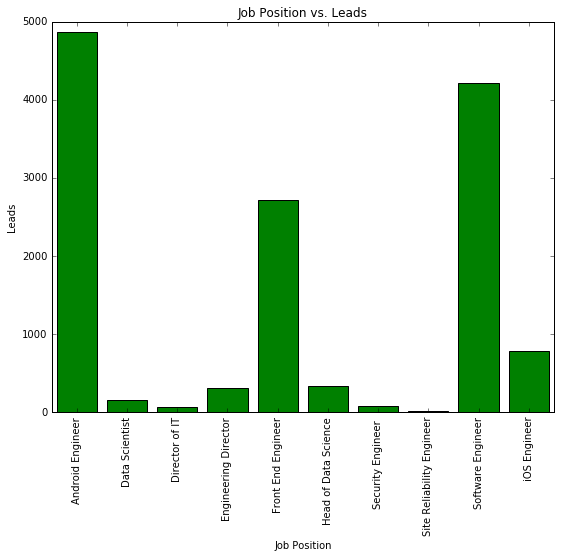

In [17]:
plot_bar(df['title'], df['leads'], 'Job Position', 'Leads', 'Job Position vs. Leads', 5000)

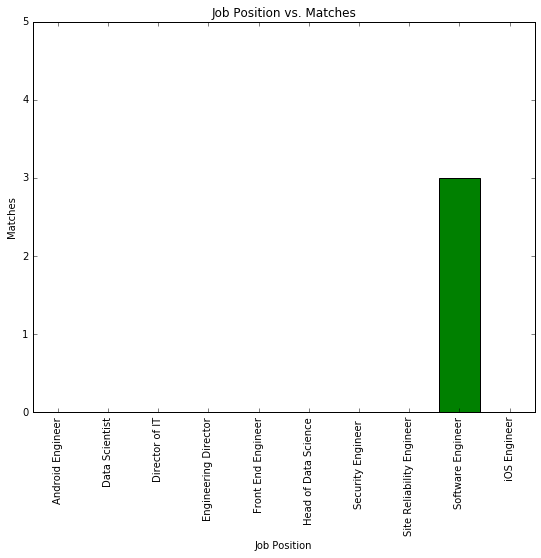

In [18]:
plot_bar(df['title'], df['matches'], 'Job Position', 'Matches', 'Job Position vs. Matches', 5)

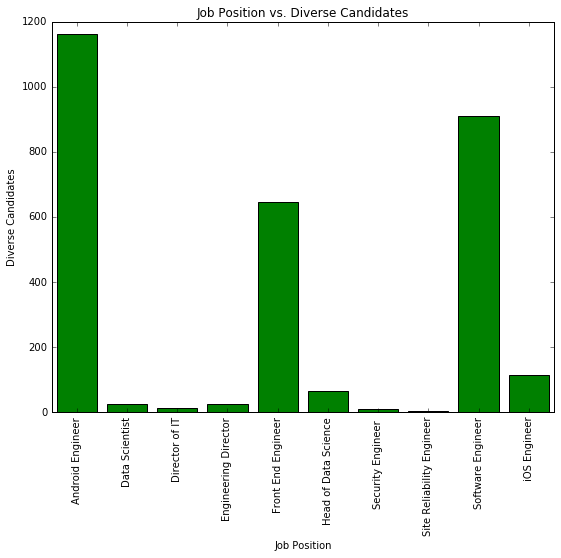

In [19]:
plot_bar(df['title'], df['diverse'], 'Job Position', 'Diverse Candidates', 'Job Position vs. Diverse Candidates', 1200)

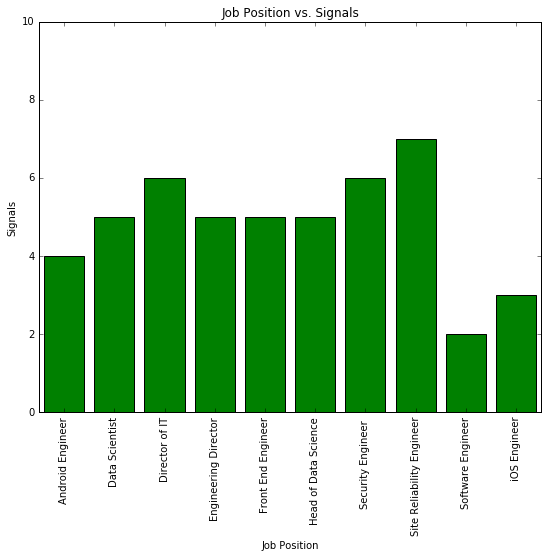

In [20]:
plot_bar(df['title'], df['signals'], 'Job Position', 'Signals', 'Job Position vs. Signals', 10)

In [21]:
def dbl_plot_bar(x, y1, y2, x_label, y_label, title, ylim):
    fig, ax = plt.subplots(figsize=(9, 7))
    lbl = x
    x = np.arange(len(x))
    pos = x + 0.4
    ax.bar(pos-0.2, y1*100, width=0.4, color='g', label='Leads %');
    ax.bar(pos+0.2, y2*100, width=0.4, color='r', label='Matches %');
    ax.set_xticks(pos+0.2);
    ax.set_xticklabels(labels=lbl, rotation='vertical');
    ax.set_xlabel(x_label);
    ax.set_ylabel(y_label);
    ax.set_title(title);
    ax.set_ylim(top=ylim);
    ax.legend();

### Double bar plot comparing diversity % in the leads we provide and the matches that Thumbtack selects

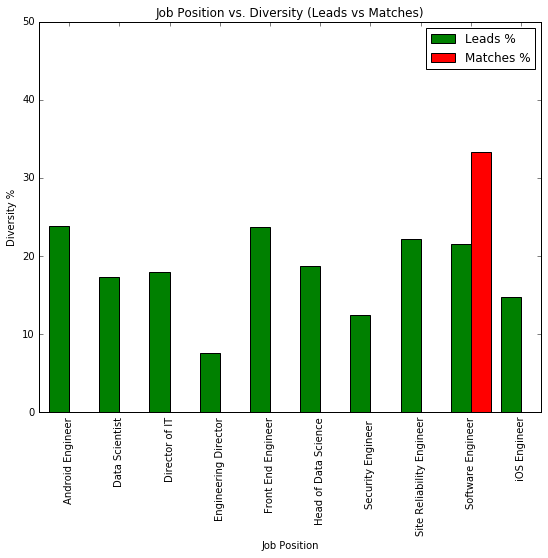

In [22]:
dbl_plot_bar(df['title'], df['per_leads_div'], 
             df['per_match_div'], 'Job Position', 'Diversity %', 
             'Job Position vs. Diversity (Leads vs Matches)', 50)